In [1]:
import sys
sys.path.insert(0, '..') 
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
relu = torch.nn.ReLU()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


/Users/alexnegron/opt/anaconda3/envs/modular_dynamics/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448812220/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


# Test bump initialization

- Initialize bumps with an impulse 
- Run dynamics equations until bumps are stable and centered where the impulse was applied

In [125]:
from src.modular_rnn import ModRNN, RingModule

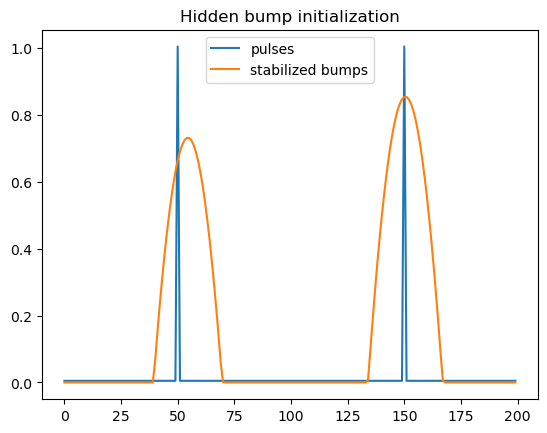

In [514]:
rnn = ModRNN(input_size=1, output_size=2)
bump_period = int(rnn.CTRNN.nNeurons / rnn.CTRNN.nBumps) # bump distance
pulse_inds = bump_period * np.arange(rnn.CTRNN.nBumps)
pulse_inds = np.concatenate((pulse_inds, rnn.CTRNN.nNeurons + pulse_inds))
pulse_inds += int(rnn.CTRNN.pulsePosition % bump_period)
pulse_inputs = torch.zeros(2 * rnn.CTRNN.nNeurons, device=rnn.CTRNN.device)
pulse_inputs[pulse_inds] = rnn.CTRNN.pulseMag

init_hidden_pre = 0.005 * torch.ones(2 * rnn.CTRNN.nNeurons, device=rnn.CTRNN.device) + pulse_inputs # initial hidden state before dynamics to stabilize bumps
init_hidden_post = rnn.CTRNN.init_hidden() # initial hidden state *after* dynamics to stabilize bumps


plt.plot(init_hidden_pre.cpu().numpy(), label='pulses')
plt.plot(init_hidden_post.detach().numpy(), label='stabilized bumps')
plt.title('Hidden bump initialization')
plt.legend()
plt.show()

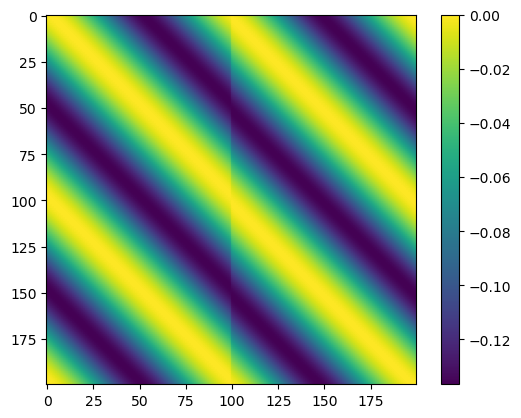

In [245]:
plt.imshow(rnn.CTRNN.wAttractor.numpy())
plt.colorbar()
plt.show()

Some remarks: 
- Every time the network is initialized, the bumps are placed at the same location. I think this only works if the training data trajectories also all start from the same location on the ring, currently $\theta_0 = 0$ rad.

# Test bump dynamics

Do the bumps move in the right direction for different values of $\omega(t)$? They should be moving in opposite directions.

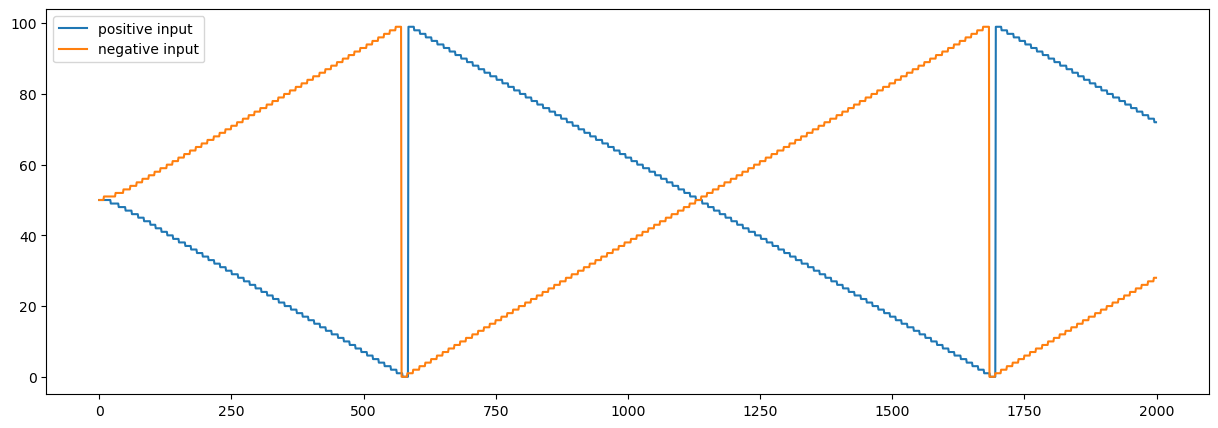

In [546]:
import matplotlib.pyplot as plt

# Initialize the model
input_size = 1  
output_size = 2

model = ModRNN(input_size,
             output_size,
             device=device,
             nNeurons=100,
             nBumps=1,
             length=30,
             gNoiseMag=None,
             fano=None,
             dt=.5,
             tau=10.0,
             alpha = 1.0,
             wWeight=11.0,
            #  wWeight=8.0,
             wShift=2,
             wScaling=True,
             restingMag=1.0,
             gammaMultiplier=1,
             pulseMag = 1.0,
             pulsePosition = 50
            )

# Initialize some hidden activity
hidden = model.CTRNN.init_hidden()

# Create a positive and a negative input
positive_input = torch.tensor([0.5]).to(device)
negative_input = torch.tensor([-0.5]).to(device)

# Define the number of steps
num_steps = 2000

# Step the dynamics forward for positive input and track the maximum position
hidden_after_positive = hidden.clone()
max_positions_positive = []
for _ in range(num_steps):
    hidden_after_positive = model.CTRNN.recurrence(positive_input, hidden_after_positive)
    max_positions_positive.append(hidden_after_positive[:model.CTRNN.nNeurons].argmax().item())

# Step the dynamics forward for negative input and track the maximum position
hidden_after_negative = hidden.clone()
max_positions_negative = []
for _ in range(num_steps):
    hidden_after_negative = model.CTRNN.recurrence(negative_input, hidden_after_negative)
    max_positions_negative.append(hidden_after_negative[:model.CTRNN.nNeurons].argmax().item())

# Plot the position of the maximum of the bump in the first ring for both positive and negative inputs
plt.figure(figsize=(15, 5))
plt.plot(max_positions_positive, label='positive input')
plt.plot(max_positions_negative, label='negative input')
plt.legend()
plt.show()

# Integrating a single trajectory

- Input data: $\omega(t)$
- Target data: $\left( \cos \left( \int_0^t \omega(s) \mathrm{d}s \right), \sin \left( \int_0^t \omega(s) \mathrm{d}s \right) \right)$; i.e. the $x,y$ coordinates of the position on the ring at time $t$.

Network is trained with supervised learning to integrate the velocity. The network is trained on a single trajectory, and the loss function is the mean squared error between the network output and the target data.

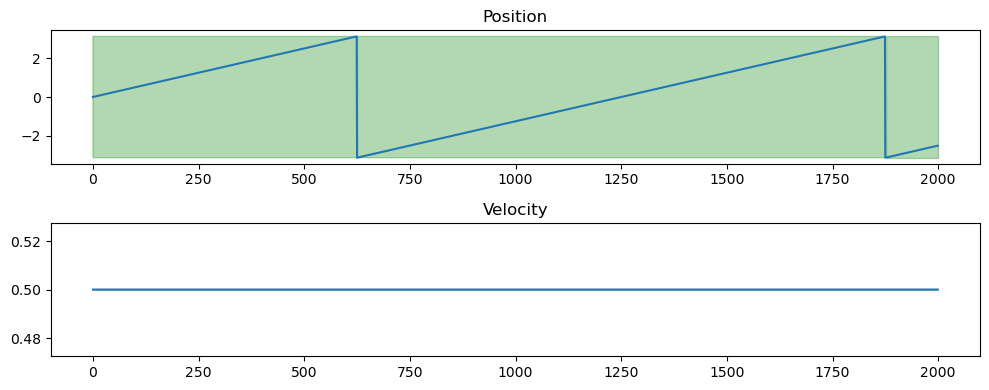

In [555]:
# training data generation
from tasks.independent_integration_task import generate_dataset

num_samples = 1
num_trajectories = 1
num_timesteps = 2000
num_flips = 5
omega_process = 'constant'
omega_value = 0.5
dt = .01

# Generate the dataset
inputs, targets = generate_dataset(num_samples,
                                   num_timesteps,
                                   num_trajectories,
                                   trajectory_type=omega_process,
                                   dt=dt,
                                   num_flips=num_flips,
                                   omega_value=omega_value,
                                   include_initial_position=False
                                   )

# Plot the dataset
traj_idx = 0
for i in range(num_samples)[::]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 4))

    # Compute the angle from the target positions
    angle = np.arctan2(targets[i, :, 2*traj_idx+1], targets[i, :, 2*traj_idx])

    # Plot corresponding position from targets
    axs[0].plot(angle)
    axs[0].set_title('Position')

    # Shade regions where position is increasing
    axs[0].fill_between(range(len(angle)), angle.min(), angle.max(), where=np.diff(angle, prepend=0) > 0, color='green', alpha=0.3)

    # Plot omega trajectory
    velocity = inputs[i, :, traj_idx]
    axs[1].plot(velocity)
    axs[1].set_title('Velocity')

    # Shade regions where velocity is positive
    axs[1].fill_between(range(len(velocity)), velocity.min(), velocity.max(), where=velocity > 0, color='green', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [556]:
print(inputs.shape)
print(targets.shape)

(1, 2000, 1)
(1, 2000, 2)


In [557]:
# initialize the network 

torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

input_size = inputs.shape[2]
output_size = targets.shape[2]

net = ModRNN(input_size,
             output_size,
             device=device,
             nNeurons=100,
             nBumps=1,
             length=30,
             gNoiseMag=None,
             fano=None,
             dt=.5,
             tau=10.0,
             alpha = 1.0,
             wWeight=11.0,
            #  wWeight=8.0,
             wShift=2,
             wScaling=True,
             restingMag=1.0,
             gammaMultiplier=1,
             pulseMag = 1.0,
             pulsePosition = 12
            )

criterion = torch.nn.MSELoss()
learning_rate = 5e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
num_epochs = 200
# clip_value = 2 # Define the gradient clip value

losses = []
perfs = []
nNeurons=100
hidden_activity = torch.zeros((num_epochs, num_samples, num_timesteps, 2*nNeurons)) # store hidden activity

for epoch in range(num_epochs):
    running_loss = 0.0
    indices = torch.randperm(num_samples)

    for i in range(num_samples):

        idx = indices[i]
        x = torch.Tensor(inputs[idx]).unsqueeze(1).to(device)
        y = torch.Tensor(targets[idx]).unsqueeze(1).to(device)

        outputs, activity = net(x)
        hidden_activity[epoch, i, :] = activity.squeeze(1).detach().cpu()[:, :]
        
        # outputs = torch.Tensor(outputs).unsqueeze(1)
        outputs = torch.Tensor(outputs)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping step after backpropagation and before optimization step
        # torch.nn.utils.clip_grad_value_(net.parameters(), clip_value)
        
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / num_samples
    losses.append(avg_loss)
    percent_complete = ((epoch+1) / num_epochs) * 100
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Average train loss: {avg_loss:.20f}')

    if running_loss/num_samples < 0.001:
        print(f'Training stopped early at epoch {epoch+1} because the average loss fell below 0.05')
        break

device = cpu
Epoch 1/200
Average train loss: 0.50430346612981757914
Epoch 2/200
Average train loss: 0.38356624331890698532
Epoch 3/200
Average train loss: 0.28593554969900869533
Epoch 4/200
Average train loss: 0.21091372947854561404
Epoch 5/200
Average train loss: 0.15663619023138541930
Epoch 6/200
Average train loss: 0.12032523944420611683
Epoch 7/200
Average train loss: 0.09897850946536544681
Epoch 8/200
Average train loss: 0.08888933404303335506
Epoch 9/200
Average train loss: 0.08600964752664791435
Epoch 10/200
Average train loss: 0.08658906619901052260
Epoch 11/200
Average train loss: 0.08794314192289169607
Epoch 12/200
Average train loss: 0.08824332456647074330
Epoch 13/200
Average train loss: 0.08672192967912030481
Epoch 14/200
Average train loss: 0.08312479101965902784
Epoch 15/200
Average train loss: 0.07781759270337694490
Epoch 16/200
Average train loss: 0.07142296243663193156
Epoch 17/200
Average train loss: 0.06445534062429816857
Epoch 18/200
Average train loss: 0.057657827

KeyboardInterrupt: 

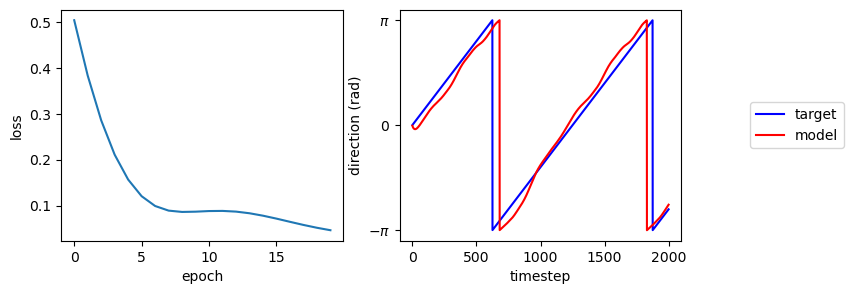

In [558]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
targets_to_plot = targets[0, :, :]
x = torch.Tensor(inputs[0, :, :]).unsqueeze(1)

# forward pass
outputs, _ = net(x)
output_arr = outputs.detach().cpu().numpy()

ax[0].plot(losses)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss') # set y label

ax[1].plot(range(targets.shape[1]), np.arctan2(targets[0, :, 1], targets[0, :, 0]), label='target', color='blue')
ax[1].plot(range(targets.shape[1]), np.arctan2(output_arr.squeeze(1)[:, 1], output_arr.squeeze(1)[:, 0]), label='model', color='red')
ax[1].set_xlabel('timestep') # set x label
ax[1].set_ylabel('direction (rad)') # set y label
ax[1].set_yticks(np.linspace(-np.pi, np.pi, 3), [r'$-\pi$', r'$0$', r'$\pi$'])
ax[1].legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.show()

In [559]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
from IPython.display import clear_output

# Define your plot function
def update(i):
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))  # Optional: Set a figure size
    plt.plot(hidden_activity[epoch-1, 0, i, :].T.detach().cpu().numpy(), 'b-', marker='o')
    plt.xlim(0, len(hidden_activity[0, 0, 0, :]))  # Set the x-limits (optional)
    plt.xlabel('Time')
    plt.title(f'Hidden activity at time {i}')

    # show the plot again after updating
    plt.show()

widget = interactive(update, i=(0, len(hidden_activity[0, 0, :, 0])-1, 10))
display(widget)


interactive(children=(IntSlider(value=990, description='i', max=1999, step=10), Output()), _dom_classes=('widg…

# Integrating two independent velocities